# 패키지 다운로드

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import confusion_matrix, classification_report

np.set_printoptions(suppress=True)


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings("ignore")

# 데이터 셋 확인

In [2]:
# '선박번호', '날짜_시간', '날짜', '시간', '위도', '경도', '대지속력', '실침로', '선수미선','점사이_거리', '시간_차이', '정박지', '평균선회반경(m)', '유속', '유향', '우행', '풍향', '풍속', '최대파고', '유의파고', '평균파고', 'answer', '유행'

In [3]:
# 데이터 불러오기
busan = pd.read_csv("../data/Busan/busan_train_full3.csv", encoding="cp949")

## 컬럼 정제

In [4]:
# '선박번호', '날짜_시간', '날짜', '시간', '위도', '경도', '대지속력', '실침로', '선수미선', '점사이_거리', '시간_차이', '정박지', '평균선회반경(m)', '유속', '유향', '우행', '풍향', '풍속', '최대파고', '유의파고', '평균파고', 'answer', '유행', 'Combined'

In [5]:
busan_test = busan[['선박번호', '날짜_시간', '정박지','평균선회반경(m)','유속', '유행', '풍향', '풍속', 'answer']]
busan_test = busan_test.dropna()
busan_test

,선박번호,날짜_시간,정박지,평균선회반경(m),유속,유행,풍향,풍속,answer
0,1,2021-01-14 22:47,3,322.0,21.3,98.0,358.0,1.2,0
1,1,2021-01-14 22:50,3,322.0,21.1,95.0,185.0,0.2,0
2,1,2021-01-14 22:56,3,322.0,19.6,92.0,284.0,0.1,0
3,1,2021-01-14 23:02,3,322.0,23.4,100.0,311.0,0.9,0
4,1,2021-01-14 23:11,3,322.0,20.7,90.0,264.0,1.7,0
...,...,...,...,...,...,...,...,...,...
251015,247,2022-04-10 17:36,3,322.0,19.1,71.0,198.0,10.1,0
251016,247,2022-04-10 17:39,3,322.0,16.9,61.0,196.0,10.6,0
251017,247,2022-04-10 17:45,3,322.0,18.2,73.0,195.0,9.2,0
251018,247,2022-04-10 17:48,3,322.0,15.9,73.0,196.0,9.4,0


In [6]:
# 결측치 없는 데이터 정제 / datetime 변환
busan_test_full = busan_test.dropna().reset_index(drop = True)
busan_test_full["날짜_시간"] = pd.to_datetime(busan_test_full["날짜_시간"])

In [7]:
# 보간법
df = pd.DataFrame()

for i in busan_test_full["선박번호"].unique():
    temp = busan_test_full[busan_test_full["선박번호"] == i]

    temp = temp.set_index('날짜_시간')
    temp = temp.resample('1T').mean().interpolate()
    df = pd.concat([df, temp], axis = 0)
    
# 보간법으로 늘어난 answer의 값을 0, 1로 조정
df.loc[df['answer'] != 1, 'answer'] = 0
df= df.reset_index()
df

,날짜_시간,선박번호,정박지,평균선회반경(m),유속,유행,풍향,풍속,answer
0,2021-01-14 22:47:00,1.0,3.0,322.0,21.300000,98.000000,358.000000,1.200000,0.0
1,2021-01-14 22:48:00,1.0,3.0,322.0,21.233333,97.000000,300.333333,0.866667,0.0
2,2021-01-14 22:49:00,1.0,3.0,322.0,21.166667,96.000000,242.666667,0.533333,0.0
3,2021-01-14 22:50:00,1.0,3.0,322.0,21.100000,95.000000,185.000000,0.200000,0.0
4,2021-01-14 22:51:00,1.0,3.0,322.0,20.850000,94.500000,201.500000,0.183333,0.0
...,...,...,...,...,...,...,...,...,...
337702,2022-04-10 17:47:00,247.0,3.0,322.0,16.666667,73.000000,195.666667,9.333333,0.0
337703,2022-04-10 17:48:00,247.0,3.0,322.0,15.900000,73.000000,196.000000,9.400000,0.0
337704,2022-04-10 17:49:00,247.0,3.0,322.0,17.100000,74.666667,197.000000,9.033333,0.0
337705,2022-04-10 17:50:00,247.0,3.0,322.0,18.300000,76.333333,198.000000,8.666667,0.0


### 보간 & 더미 데이터

In [8]:
dummy = pd.get_dummies(df['정박지'])

dummy_busan = pd.concat([dummy, df[['선박번호', '유속', '유행', '풍향', '풍속', 'answer']]], axis = 1)

### 학습데이터 준비

In [9]:
busan_df = dummy_busan[['선박번호', "유속", "유행", "풍향","풍속",1,2,3,4,5,"answer"]]
busan_df

,선박번호,유속,유행,풍향,풍속,1.0,2.0,3.0,4.0,5.0,answer
0,1.0,21.300000,98.000000,358.000000,1.200000,0,0,1,0,0,0.0
1,1.0,21.233333,97.000000,300.333333,0.866667,0,0,1,0,0,0.0
2,1.0,21.166667,96.000000,242.666667,0.533333,0,0,1,0,0,0.0
3,1.0,21.100000,95.000000,185.000000,0.200000,0,0,1,0,0,0.0
4,1.0,20.850000,94.500000,201.500000,0.183333,0,0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
337702,247.0,16.666667,73.000000,195.666667,9.333333,0,0,1,0,0,0.0
337703,247.0,15.900000,73.000000,196.000000,9.400000,0,0,1,0,0,0.0
337704,247.0,17.100000,74.666667,197.000000,9.033333,0,0,1,0,0,0.0
337705,247.0,18.300000,76.333333,198.000000,8.666667,0,0,1,0,0,0.0


# 데이터 표준화
- 전체 데이터를 표준화

In [10]:
busan = busan_df.values
dataset = busan[:, 1:5]
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)
dataset = (dataset-data_mean)/data_std
    
remain = busan[:, (0,5,6,7,8,9)]
    
dataset = np.concatenate((np.reshape(remain[:, 0], (-1,1)), dataset), axis=1)
dataset = np.concatenate((dataset,remain[:, 1:]), axis=1)

study_length = 60
expect_period= 60

data = []
label = []
boat_num=np.unique(dataset [:,0])
np.random.shuffle(boat_num)

for j in boat_num:
    temp=dataset[dataset[:,0]==j]
    for i in range(len(temp) - study_length - expect_period):
        data.append(dataset[i:i+study_length, 1:-1])
        label.append(dataset[i+study_length+expect_period,-1])

In [11]:
# 학습 - 평가 데이터 분리
train_test_split = int(len(label)*0.8)
data_split = np.split(data, [train_test_split], axis=0)
label_split = np.split(label, [train_test_split], axis=0)

data_train = data_split[0]
data_test = data_split[1]

label_train = label_split[0]
label_test = label_split[1]


# 결과 확인
# label_train = np.reshape(label_train,(-1,1))
# label_test = np.reshape(label_test,(-1,1))
print(data_train.shape)  # (262245, 15, 9)
print(data_test.shape)  # (65562, 15, 9)

print(label_train.shape)  #(262245, )
print(label_test.shape)  #(65562, )

(249045, 60, 8)
(62262, 60, 8)
(249045,)
(62262,)


# 싱글 스텝 예측
- 과거 히스토리가 주어지면 미래의 값 한 점을 예측

## 하이퍼 파라매터 설정

In [12]:
BATCH_SIZE = 32
# 모델 학습 시 사용할 데이터의 크기
EVALUATION_INTERVAL = 1
# TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 20
# 전체 학습 데이터를 학습 반복 단위
tf.random.set_seed(13)

## 학습 및 평가 데이터 추출

In [13]:
# data_train = data_split[0]
# data_test = data_split[1]

# label_train = label_split[0]
# label_test = label_split[1]

BUFFER_SIZE = 100
# 모델 학습 시 사용할 데이터의 크기
# 데이터셋 크기의 10% ~ 20%

train_data = tf.data.Dataset.from_tensor_slices((data_train, label_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data = tf.data.Dataset.from_tensor_slices((data_test, label_test))
val_data = val_data.batch(BATCH_SIZE)

## LSTM 모델 구축 및 학습

In [14]:
from tensorflow.keras import layers, optimizers, losses, metrics

# 여기부터
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(60,8)))
#model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Compile the model
# model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
#               loss=losses.binary_crossentropy,
#               metrics=[metrics.binary_accuracy])

# Train the model
history = model.fit(train_data,
                    epochs=20,
                    batch_size=BATCH_SIZE,
                    validation_data=val_data,
                    verbose=1)

Epoch 1/20
7783/7783 [==============================] - 97s 12ms/step - loss: 0.0856 - accuracy: 0.9779 - val_loss: 0.0266 - val_accuracy: 0.9914
Epoch 2/20
7783/7783 [==============================] - 91s 12ms/step - loss: 0.0246 - accuracy: 0.9902 - val_loss: 0.0207 - val_accuracy: 0.9930
Epoch 3/20
7783/7783 [==============================] - 92s 12ms/step - loss: 0.0235 - accuracy: 0.9900 - val_loss: 0.0097 - val_accuracy: 0.9944
Epoch 4/20
7783/7783 [==============================] - 94s 12ms/step - loss: 0.0159 - accuracy: 0.9926 - val_loss: 0.0079 - val_accuracy: 0.9946
Epoch 5/20
7783/7783 [==============================] - 93s 12ms/step - loss: 0.0106 - accuracy: 0.9954 - val_loss: 0.0049 - val_accuracy: 0.9977
Epoch 6/20
7783/7783 [==============================] - 98s 13ms/step - loss: 0.0135 - accuracy: 0.9950 - val_loss: 0.0205 - val_accuracy: 0.9941
Epoch 7/20
7783/7783 [==============================] - 107s 14ms/step - loss: 0.0084 - accuracy: 0.9963 - val_loss: 9.3516e

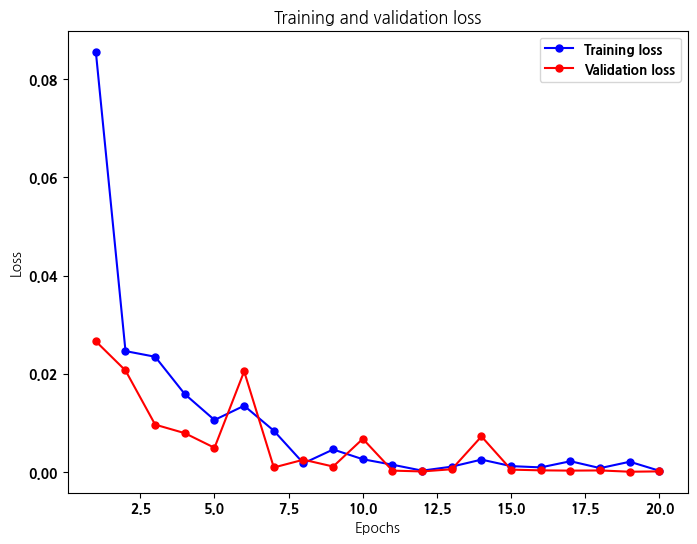

In [23]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-o', label='Training loss',markersize=5)  # ‘bo’는 파란색 점을 의미합니다.
plt.plot(epochs, val_loss, 'r-o', label='Validation loss',markersize=5) # ‘b’는 파란색 실선을 의미합니다.
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
predictions= np.round(model.predict(data_test)).flatten()
label_test = label_test
confusion = confusion_matrix(label_test, predictions)
print("Confusion Matrix:")
print(confusion)

# Generate classification report
classification = classification_report(label_test, predictions)
print("Classification Report:")
print(classification)

1946/1946 [==============================] - 8s 4ms/step
Confusion Matrix:
[[56122     0]
 [    5  6135]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56122
         1.0       1.00      1.00      1.00      6140

    accuracy                           1.00     62262
   macro avg       1.00      1.00      1.00     62262
weighted avg       1.00      1.00      1.00     62262



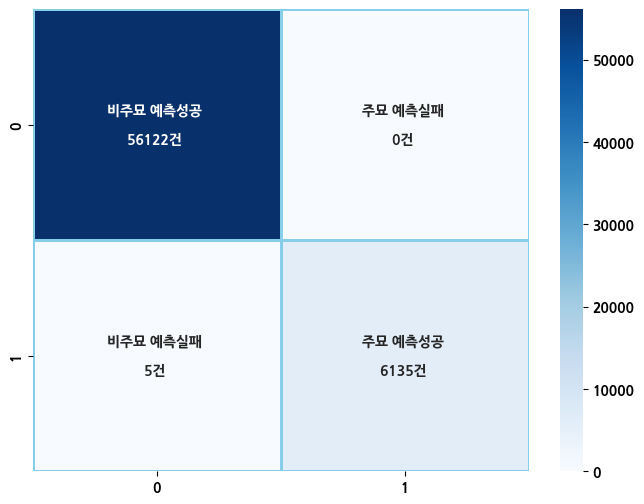

CSI: 0.999


In [25]:
import seaborn as sns 
group_names = ['비주묘 예측성공','주묘 예측실패','비주묘 예측실패','주묘 예측성공']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1} \n\n{v2}건 " for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues',linewidths=1, linecolor='skyblue')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] =10
plt.show()

print(f'CSI: {confusion[1][1]/(confusion[1][0]+confusion[1][1]+confusion[0][1]):.3f}')

In [27]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
predictions= np.round(model.predict(data_test)).flatten()
confusion = confusion_matrix(label_test, predictions)
print("Confusion Matrix:")
print(confusion)

# Generate classification report
classification = classification_report(label_test, predictions)
print("Classification Report:")
print(classification)

1946/1946 [==============================] - 8s 4ms/step
Confusion Matrix:
[[56122     0]
 [    5  6135]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56122
         1.0       1.00      1.00      1.00      6140

    accuracy                           1.00     62262
   macro avg       1.00      1.00      1.00     62262
weighted avg       1.00      1.00      1.00     62262



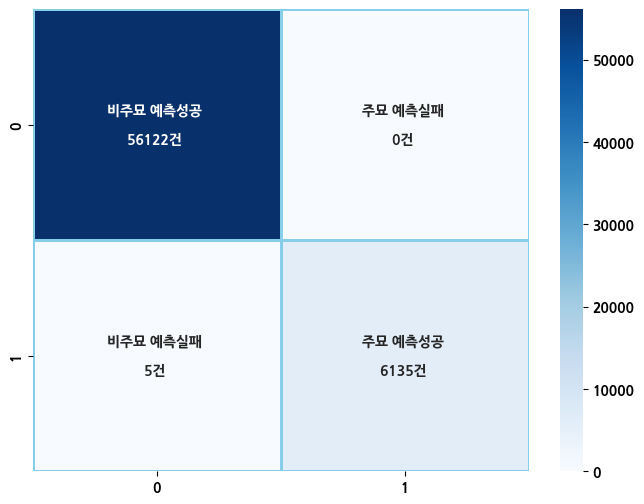

CSI: 0.999


In [28]:
import seaborn as sns 
group_names = ['비주묘 예측성공','주묘 예측실패','비주묘 예측실패','주묘 예측성공']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     confusion.flatten()/np.sum(confusion)]
labels = [f"{v1} \n\n{v2}건 " for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion, annot=labels, fmt="", cmap='Blues',linewidths=1, linecolor='skyblue')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] =10
plt.show()

print(f'CSI: {confusion[1][1]/(confusion[1][0]+confusion[1][1]+confusion[0][1]):.3f}')

# 모델 저장

In [20]:
# from keras.models import load_model

# model.save('./LSTM.h5')



In [21]:
# import pickle

# # 훈련된 딥러닝 모델을 가정합니다.

# # 모델을 피클 파일로 저장합니다.
# filename = "./LSTM.pkl"
# with open(filename, "wb") as f:
#     pickle.dump(model, f)
    
# f.close()

# 모델 불러오기

In [22]:
from keras.models import load_model

multi_step_model = load_model('0329_1059_Demand.h5')

OSError: No file or directory found at 0329_1059_Demand.h5